In [116]:
import pandas as pd #for file operations read/write
import seaborn as sns
import matplotlib.pyplot as plt #to plot visualization
import os #directory operations
import numpy as np #for RMSE calculation

In [117]:
# File paths
data_path = 'C:\\Users\\Fawaz\\Desktop\\Learning\\IITD - Data and Decision Science\\Student Presentations\\GP16 Capstone Data Science'
file_path = os.path.join(data_path, 'sales_data.csv')

# Load CSV with encoding fix. Encoding fix is needed especially file is converted to csv from excel or other source.
sales_data = pd.read_csv(file_path, encoding='ISO-8859-1')


In [118]:
#Change product line here to populate the moving average and exponential smoothening for different category.
#In our data, product lines are Classic Cars, Motorcycles, Planes, Ships, Trains, Trucks and Buses and Vintage Cars
#In this example Filter for "Classic Cars" product line

filter_data = sales_data[(sales_data['PRODUCTLINE'] == 'Classic Cars') & (sales_data['STATUS'] == 'Shipped')]

# Group by YEAR_ID and MONTH_ID, summing up sales
product_sales = filter_data.groupby(['YEAR_ID', 'MONTH_ID'])['SALES'].sum().reset_index()

#For visualization purpose add continous sequence order for all months
product_sales['Series_ID'] = range(1, len(product_sales) + 1)

# Reorder columns to put 'Series_ID' first
cols = ['Series_ID'] + [col for col in product_sales.columns if col != 'Series_ID']
product_sales = product_sales[cols]

# Display the result
product_sales

,Series_ID,YEAR_ID,MONTH_ID,SALES
0,1,2003,1,41191.78
1,2,2003,2,20464.41
2,3,2003,3,105026.68
3,4,2003,4,59873.60
4,5,2003,5,98179.48
5,6,2003,6,50256.79
6,7,2003,7,94055.58
7,8,2003,8,48406.61
8,9,2003,9,137666.87
9,10,2003,10,228489.18


In [105]:
# Create a new row as a dictionary, month for which SALES needs to be predicted.
new_row = {
    'Series_ID': 30,
    'YEAR_ID': 2005,
    'MONTH_ID': 6,
    'SALES': 0
}

# Append the new row to the DataFrame
product_sales = pd.concat([product_sales, pd.DataFrame([new_row])], ignore_index=True)

# Sort the DataFrame by Series_ID to maintain order
product_sales = product_sales.sort_values(by='Series_ID').reset_index(drop=True)

# Display the updated DataFrame
product_sales


,Series_ID,YEAR_ID,MONTH_ID,SALES
0,1,2003,1,41191.78
1,2,2003,2,20464.41
2,3,2003,3,105026.68
3,4,2003,4,59873.60
4,5,2003,5,98179.48
5,6,2003,6,50256.79
6,7,2003,7,94055.58
7,8,2003,8,48406.61
8,9,2003,9,137666.87
9,10,2003,10,228489.18


In [106]:
# Calculate the 3-month moving average for Classic Cars sales
product_sales['3SMV'] = product_sales['SALES'].rolling(window=3).mean().shift(1)

# Calculate the 3-month moving average for Classic Cars sales
product_sales['5SMV'] = product_sales['SALES'].rolling(window=5).mean().shift(1)

#======== Weighted average calculation ==========
# Define weights
weights = [0.00, 0.30, 0.70] #Identified optimized weightage value using excel solver.

# Calculate the weighted moving average for each row using the last 3 months
product_sales['Opt_WMV'] = product_sales['SALES'].rolling(window=3).apply(
    lambda x: np.dot(x, weights) if len(x) == 3 else np.nan, raw=True
).shift(1)

#========= Exponential Smoothening ================
#Calculate Exponential smootherning with alpha value identified using Excel solver
alpha = 0.44

product_sales['Exp_Smooth'] = np.nan

# First row: Exp_Smoothening = actual sales
product_sales.at[0, 'Exp_Smooth'] = product_sales.at[0, 'SALES']

# From second row onwards:
for i in range(1, len(product_sales)):
    prev_actual = product_sales.at[i-1, 'SALES']       # previous month actual sales
    prev_smooth = product_sales.at[i-1, 'Exp_Smooth']   # previous month smooth value
    product_sales.at[i, 'Exp_Smooth'] = alpha * prev_actual + (1 - alpha) * prev_smooth

# Display the updated table
product_sales

,Series_ID,YEAR_ID,MONTH_ID,SALES,3SMV,5SMV,Opt_WMV,Exp_Smooth
0,1,2003,1,41191.78,NaN,NaN,NaN,41191.780000
1,2,2003,2,20464.41,NaN,NaN,NaN,41191.780000
2,3,2003,3,105026.68,NaN,NaN,NaN,32071.737200
3,4,2003,4,59873.60,55560.956667,NaN,79657.999,64171.912032
4,5,2003,5,98179.48,61788.230000,NaN,73419.524,62280.654738
5,6,2003,6,50256.79,87693.253333,64947.190,86687.716,78076.137853
6,7,2003,7,94055.58,69436.623333,66760.192,64633.597,65835.624798
7,8,2003,8,48406.61,80830.616667,81478.426,80915.943,78252.405087
8,9,2003,9,137666.87,64239.660000,70154.412,62101.301,65120.255249
9,10,2003,10,228489.18,93376.353333,85713.066,110888.792,97040.765739


In [107]:
# Calculate row level RMSE (absolute error) for each method
product_sales['RMSE_3SMV'] = np.sqrt((product_sales['SALES'] - product_sales['3SMV'])**2)
product_sales['RMSE_5SMV'] = np.sqrt((product_sales['SALES'] - product_sales['5SMV'])**2)
product_sales['RMSE_Opt_WMV'] = np.sqrt((product_sales['SALES'] - product_sales['Opt_WMV'])**2)
product_sales['RMSE_Exp_Smooth'] = np.sqrt((product_sales['SALES'] - product_sales['Exp_Smooth'])**2)

# Display the updated DataFrame
product_sales


,Series_ID,YEAR_ID,MONTH_ID,SALES,3SMV,5SMV,Opt_WMV,Exp_Smooth,RMSE_3SMV,RMSE_5SMV,RMSE_Opt_WMV,RMSE_Exp_Smooth
0,1,2003,1,41191.78,NaN,NaN,NaN,41191.780000,NaN,NaN,NaN,0.000000
1,2,2003,2,20464.41,NaN,NaN,NaN,41191.780000,NaN,NaN,NaN,20727.370000
2,3,2003,3,105026.68,NaN,NaN,NaN,32071.737200,NaN,NaN,NaN,72954.942800
3,4,2003,4,59873.60,55560.956667,NaN,79657.999,64171.912032,4312.643333,NaN,19784.399,4298.312032
4,5,2003,5,98179.48,61788.230000,NaN,73419.524,62280.654738,36391.250000,NaN,24759.956,35898.825262
5,6,2003,6,50256.79,87693.253333,64947.190,86687.716,78076.137853,37436.463333,14690.400,36430.926,27819.347853
6,7,2003,7,94055.58,69436.623333,66760.192,64633.597,65835.624798,24618.956667,27295.388,29421.983,28219.955202
7,8,2003,8,48406.61,80830.616667,81478.426,80915.943,78252.405087,32424.006667,33071.816,32509.333,29845.795087
8,9,2003,9,137666.87,64239.660000,70154.412,62101.301,65120.255249,73427.210000,67512.458,75565.569,72546.614751
9,10,2003,10,228489.18,93376.353333,85713.066,110888.792,97040.765739,135112.826667,142776.114,117600.388,131448.414261


In [96]:
product_sales.tail() #check if SALES is predicted for future month by all different methods.

,Series_ID,YEAR_ID,MONTH_ID,SALES,3SMV,5SMV,Opt_WMV,Exp_Smooth,RMSE_3SMV,RMSE_5SMV,RMSE_Opt_WMV,RMSE_Exp_Smooth
25,26,2005,2,146148.57,195960.776667,181749.070,114523.200,158412.137280,49812.206667,35600.500,31625.370,12263.567280
26,27,2005,3,91389.86,122621.976667,191577.542,138309.993,153016.167677,31232.116667,100187.682,46920.133,61626.307677
27,28,2005,4,45341.79,119186.136667,165084.152,107817.473,125900.592299,73844.346667,119742.362,62475.683,80558.802299
28,29,2005,5,123859.57,94293.406667,100919.516,59156.211,90454.719287,29566.163333,22940.054,64703.359,33404.850713
29,30,2005,6,0.00,86863.740000,105351.954,100304.236,105152.853601,86863.740000,105351.954,100304.236,105152.853601


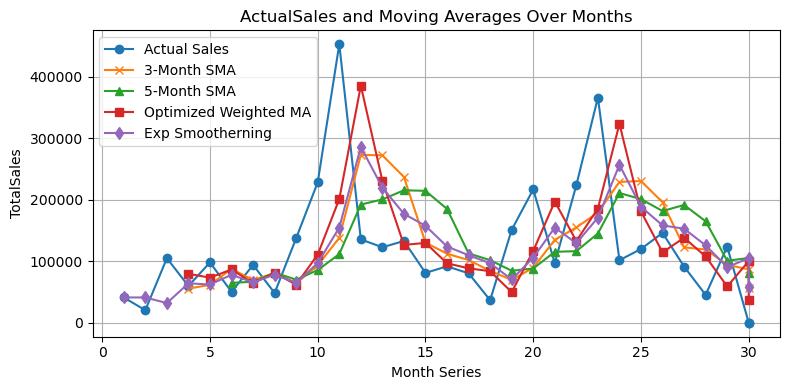

In [108]:
#Plot Actual Sales vs different predicted values


plt.figure(figsize=(8, 4))

plt.plot(product_sales['Series_ID'], product_sales['SALES'], label='Actual Sales', marker='o')
plt.plot(product_sales['Series_ID'], product_sales['3SMV'], label='3-Month SMA', marker='x')
plt.plot(product_sales['Series_ID'], product_sales['5SMV'], label='5-Month SMA', marker='^')
plt.plot(product_sales['Series_ID'], product_sales['Opt_WMV'], label='Optimized Weighted MA', marker='s')
plt.plot(product_sales['Series_ID'], product_sales['Exp_Smooth'], label='Exp Smootherning', marker='d')

plt.title('ActualSales and Moving Averages Over Months')
plt.xlabel('Month Series')
plt.ylabel('TotalSales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

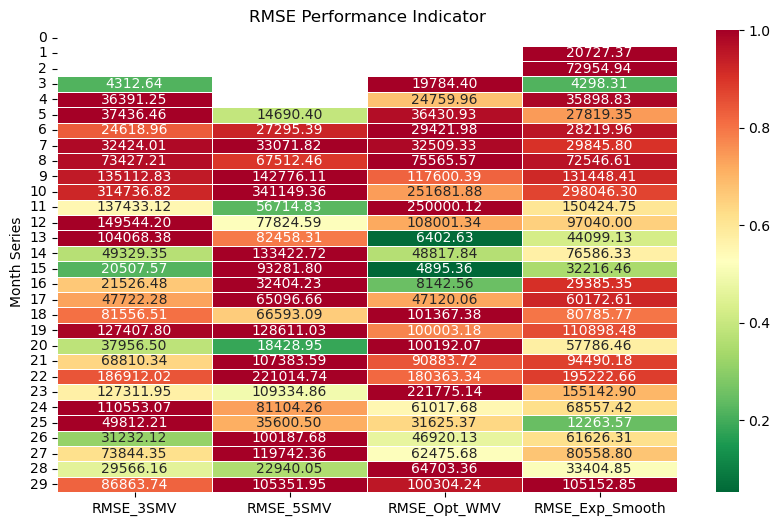

In [109]:
# Heatmap result of RMSE values.
filter_product_sales = product_sales.iloc[:-1]  # Select all rows except the last one which is the predicted value.
rmse_df = filter_product_sales[['Series_ID', 'RMSE_3SMV', 'RMSE_5SMV', 'RMSE_Opt_WMV', 'RMSE_Exp_Smooth']]

# Normalize RMSE values row wise for color scaling
norm_rmse = rmse_df[['RMSE_3SMV', 'RMSE_5SMV', 'RMSE_Opt_WMV', 'RMSE_Exp_Smooth']].div(
    rmse_df[['RMSE_3SMV', 'RMSE_5SMV', 'RMSE_Opt_WMV', 'RMSE_Exp_Smooth']].max(axis=1), axis=0)

# Set up the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(norm_rmse, annot=rmse_df[['RMSE_3SMV', 'RMSE_5SMV', 'RMSE_Opt_WMV', 'RMSE_Exp_Smooth']], 
            cmap='RdYlGn_r', cbar=True, fmt=".2f", linewidths=0.5)

# Add title and labels
plt.title("RMSE Performance Indicator")
#plt.xlabel("RMSE Results")
plt.ylabel("Month Series")
plt.show()



In [25]:
#Save the DataFrame to an Excel file
product_sales.to_excel('SALES_Prediction.xlsx', index=False)

print("Final results saved to 'SALES_Prediction.xlsx'")

Final results saved to 'SALES_Prediction.xlsx'
